Makemore takes one text file as input, where each line is assumed to be one training thing, and generates more things like it. Under the hood, it is an autoregressive character-level language model, with a wide choice of models from bigrams all the way to a Transformer (exactly as seen in GPT). For example, we can feed it a database of names, and makemore will generate cool baby name ideas that all sound name-like, but are not already existing names. Or if we feed it a database of company names then we can generate new ideas for a name of a company. Or we can just feed it valid scrabble words and generate english-like babble.
This is not meant to be too heavyweight library with a billion switches and knobs. It is one hackable file, and is mostly intended for educational purposes. PyTorch is the only requirement.

Current implementation follows a few key papers:

Bigram (one character predicts the next one with a lookup table of counts)
MLP, following Bengio et al. 2003
CNN, following DeepMind WaveNet 2016 (in progress...)
RNN, following Mikolov et al. 2010
LSTM, following Graves et al. 2014
GRU, following Kyunghyun Cho et al. 2014
Transformer, following Vaswani et al. 2017


In [35]:
words = open('../data/names.txt', 'r').read().splitlines()

In [3]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
len(words)

32033

## First Language Model


In [8]:
# let's look at bi-gram model

for w in words[:1]:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        print(ch1, ch2)

<S> e
e m
m m
m a
a <E>


In [14]:
# now we need to count the frequency of each pair
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1  # if bigram is not in b, return 0. that's why we need get


In [17]:
sorted(b.items(), key=lambda x: -x[1])

[(('a', 'a'), 33885),
 (('<S>', '<S>'), 32033),
 (('<E>', '<E>'), 32033),
 (('e', 'e'), 20423),
 (('n', 'n'), 18327),
 (('i', 'i'), 17701),
 (('l', 'l'), 13958),
 (('r', 'r'), 12700),
 (('y', 'y'), 9776),
 (('s', 's'), 8106),
 (('o', 'o'), 7934),
 (('h', 'h'), 7616),
 (('m', 'm'), 6642),
 (('t', 't'), 5570),
 (('d', 'd'), 5496),
 (('k', 'k'), 5040),
 (('c', 'c'), 3532),
 (('u', 'u'), 3135),
 (('j', 'j'), 2900),
 (('b', 'b'), 2645),
 (('v', 'v'), 2573),
 (('z', 'z'), 2398),
 (('g', 'g'), 1927),
 (('p', 'p'), 1026),
 (('w', 'w'), 929),
 (('f', 'f'), 905),
 (('x', 'x'), 697),
 (('q', 'q'), 272)]

In [18]:
# now store the that frequency in a matrix using pytorch
# in that matrix rows are the first character and columns are the second character
# so we can get the frequency of a pair by matrix[ch1][ch2]
import torch


In [36]:
# mapping form character to index
chars = sorted(list(set(''.join(words))))
stoi = {s:i for i, s in enumerate(chars)}
stoi['<S>'] = 26
stoi['<E>'] = 27

In [37]:
N = torch.zeros((28,28), dtype=torch.int32)
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

In [26]:
import matplotlib.pyplot as plt


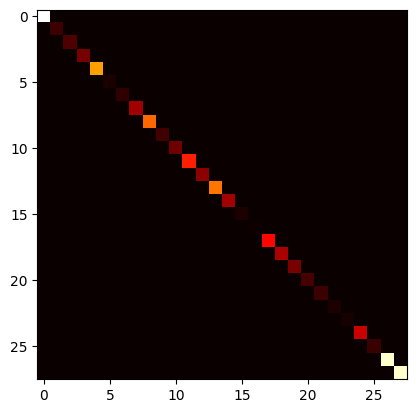

In [29]:
plt.imshow(N, cmap='hot', interpolation='nearest')

In [38]:
# integer to string
iots = {i:s for s,i in stoi.items()}

(-0.5, 27.5, 27.5, -0.5)

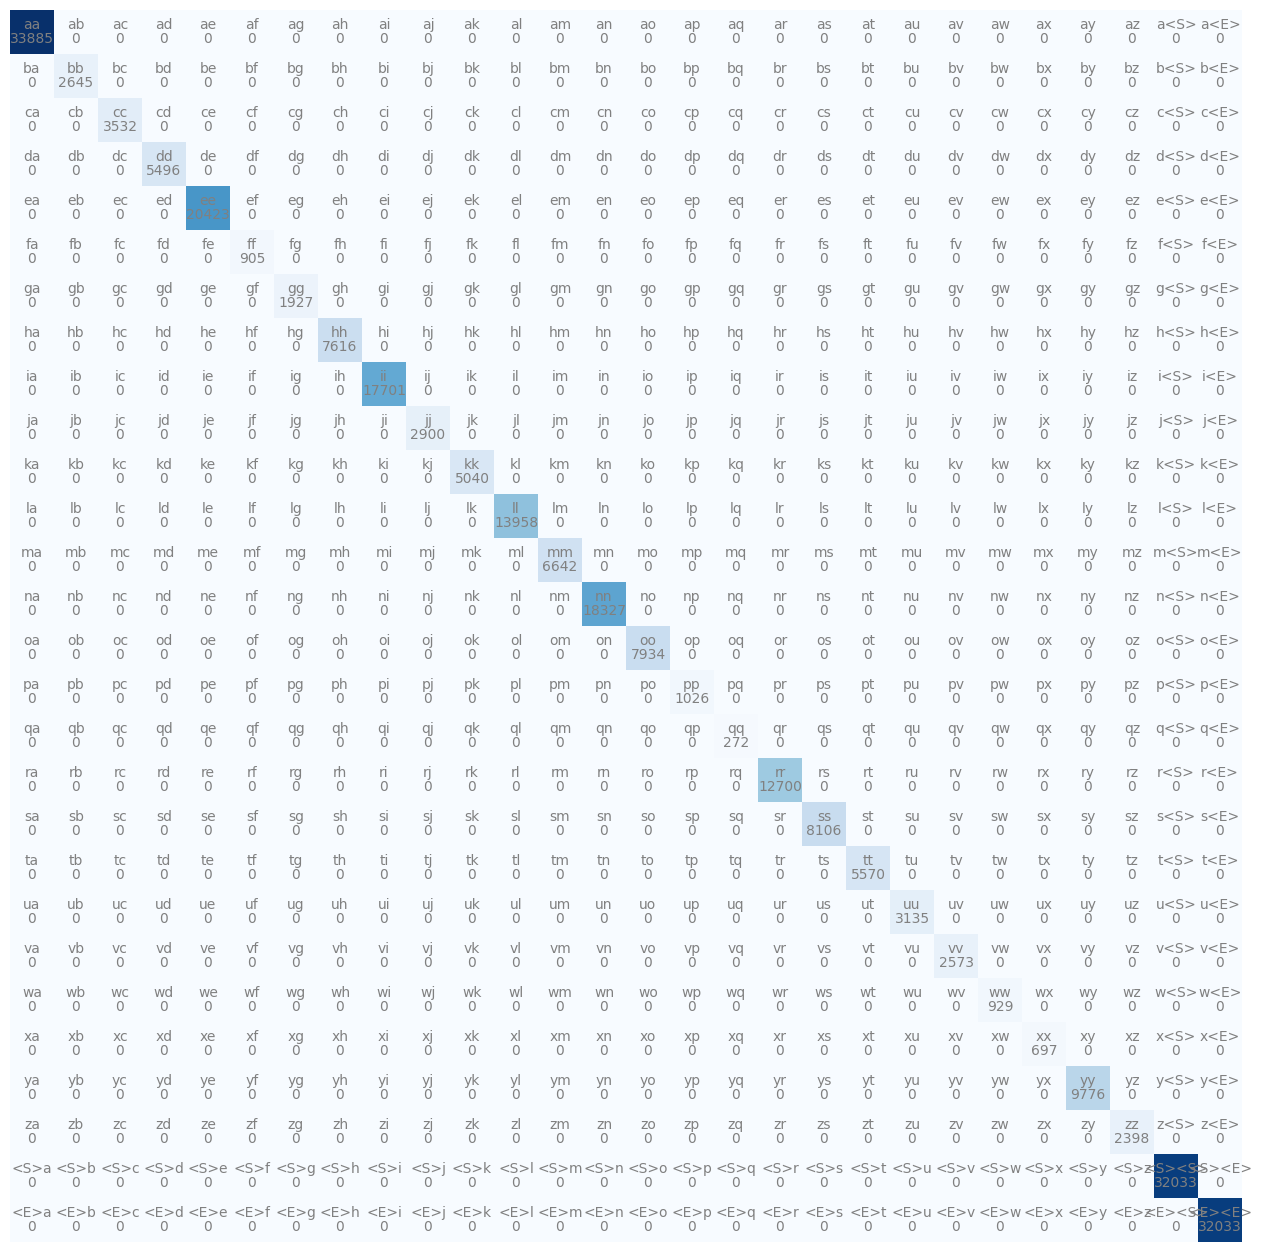

In [39]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(28):
    for j in range(28):
        chstr = iots[i] + iots[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j, i, N[i, j].item(), ha='center', va='top', color='gray')
plt.axis('off')

In [ ]:
# <E> is the alst one and the bi-gram it ahs zero frequency in the alst row of the matrix

In [92]:
N = torch.zeros((27,27), dtype=torch.int32)

In [93]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [53]:
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1

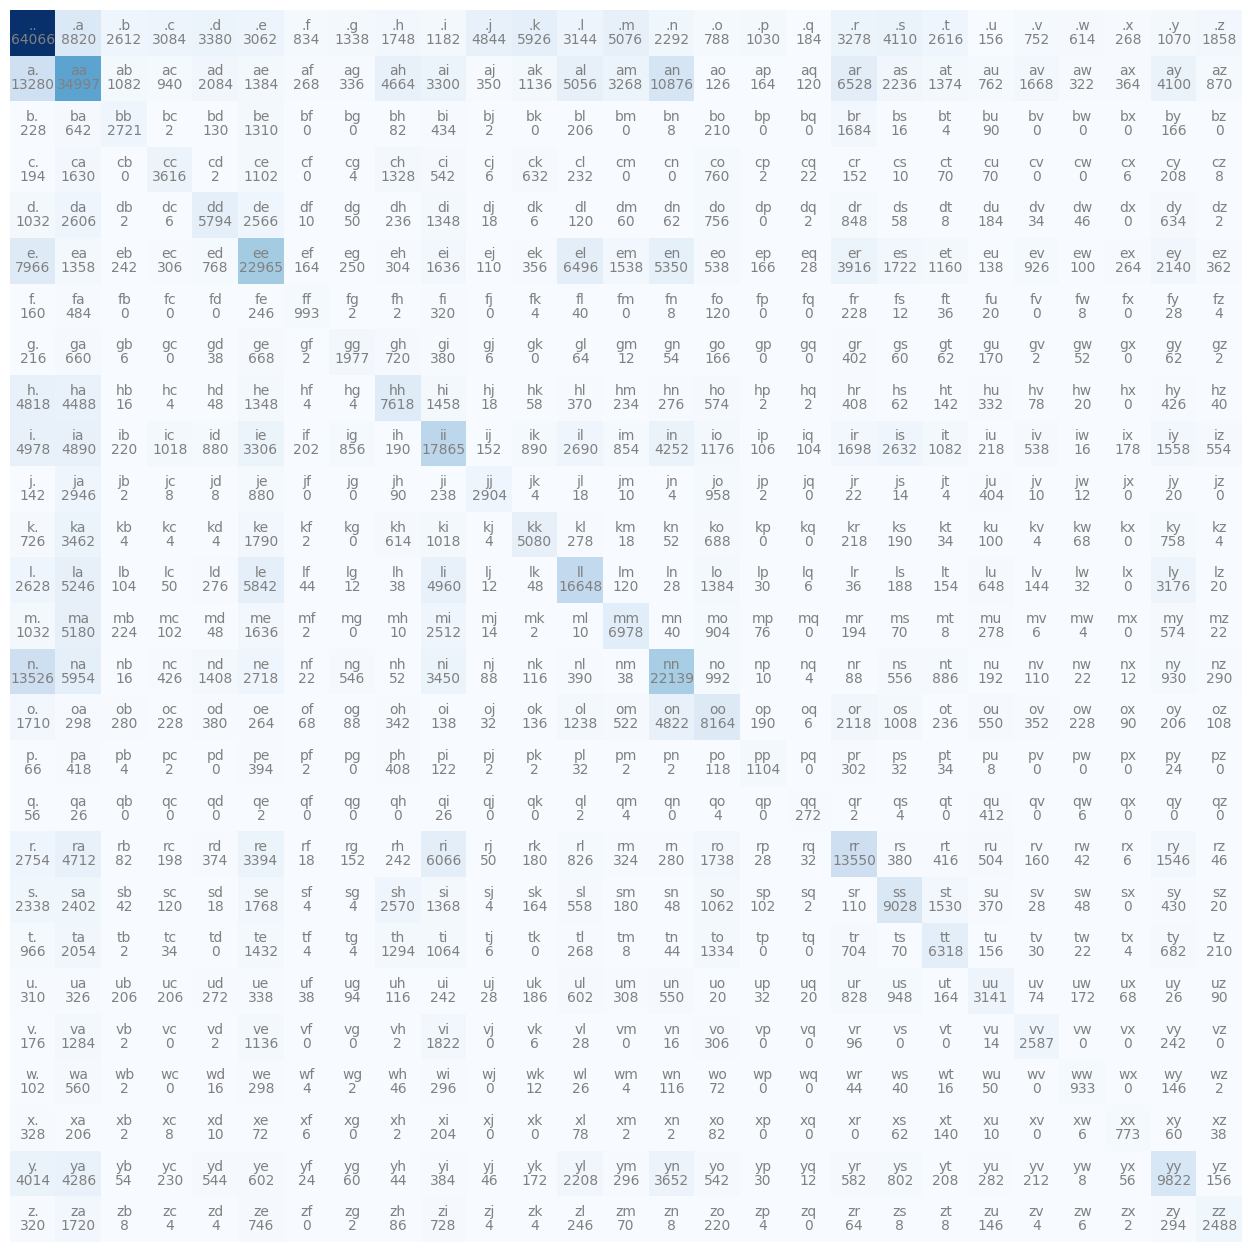

In [56]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

In [58]:
N[0, :].shape

torch.Size([27])

In [59]:
p = N[0].float() 
p = p / p.sum()
p

tensor([0.5000, 0.0688, 0.0204, 0.0241, 0.0264, 0.0239, 0.0065, 0.0104, 0.0136,
        0.0092, 0.0378, 0.0462, 0.0245, 0.0396, 0.0179, 0.0061, 0.0080, 0.0014,
        0.0256, 0.0321, 0.0204, 0.0012, 0.0059, 0.0048, 0.0021, 0.0084, 0.0145])

In [61]:
# to get deterministic results
g = torch.Generator().manual_seed(2147483647)
p = torch.rand(3, generator=g) # get random samples from a uniform distribution
p = p / p.sum()
p


tensor([0.6064, 0.3033, 0.0903])

In [65]:
# sample from a multinomial distribution
torch.multinomial(p, 100, replacement=True, generator=g)

tensor([0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
        2, 2, 0, 1, 2, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2,
        1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0,
        0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 1, 0, 1])

In [70]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, 1, replacement=True, generator=g).item()
itos[ix]

'.'

In [73]:
g = torch.Generator().manual_seed(2147483647)
for i in range(20):
    ix = 0
    out = []
    while True:
        # p = N[ix].float()
        # p = p / p.sum()
        # lets make the model more uniform
        p = torch.ones(27) / 27.0 # untrained model, every character is equally likely
        ix = torch.multinomial(p, 1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))



cexzm.
zoglkurkicqzktyhwmvmzimjttainrlkfukzkktda.
sfcxvpubjtbhrmgotzx.
iczixqctvujkwptedogkkjemkmmsidguenkbvgynywftbspmhwcivgbvtahlvsu.
dsdxxblnwglhpyiw.
igwnjwrpfdwipkwzkm.
desu.
firmt.
gbiksjbquabsvoth.
kuysxqevhcmrbxmcwyhrrjenvxmvpfkmwmghfvjzxobomysox.
gbptjapxweegpfwhccfyzfvksiiqmvwbhmiwqmdgzqsamjhgamcxwmmk.
iswcxfmbalcslhy.
fpycvasvz.
bqzazeunschck.
wnkojuoxyvtvfiwksddugnkul.
fuwfcgjz.
abl.
j.
nuuutstofgqzubbo.
rdubpknhmd.


In [87]:
P = N.float()
# we want to normalize the rows by dividing by the sum of the row
# P = P / P.sum(dim=1, keepdim=True) # keepdim=True to keep the dimension of the sum
# above opeeration is broadcasting, it is like dividing each row by the sum of the row
# replace with in-place operation
P /= P.sum(dim=1, keepdim=True)

CAREFUL with broadcasting

P = (27, 27)
P_norm = (27, 1) # P = P / P.sum(dim=1, keepdim=True)

ABOVE will normalise row-wise 
Whereas by not providing keepdim to True will normalise column-wise

P = (27, 27)
P_norm = (1, 27) # P = P / P.sum(dim=1)


In [85]:
P[:, 0].sum()

tensor(2.5148)

In [86]:
g = torch.Generator().manual_seed(2147483647)
for i in range(20):
    ix = 0
    out = []
    while True:
        #below two lines are inefficient. we can sore teh probabilities in a new matrix P
        # p = N[ix].float()
        # p = p / p.sum()
        p = P[ix]
        # lets make the model more uniform
        # p = torch.ones(27) / 27.0 # untrained model, every character is equally likely
        ix = torch.multinomial(p, 1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))



.
ee.
.
.
.
jalluraiiazityyn.
.
.
.
.
mmmmaan.
llaak.
kkkaa.
sssiiieelllerriitti.
moliiilaau.
kkkkedaaaaahava.
sshe.
.
nkaviynyyyylspiiinnnnnvorrllee.
.


In [94]:
# quality of bi-gram simple model
g = torch.Generator().manual_seed(2147483647)
for i in range(5):
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, 1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))
    


.
ee.
.
.
.


## Quality of the Model

In [98]:
for w in words[:3]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        print(f'{ch1}{ch2}: {prob: .4f} {logprob: .4f}')

.e:  0.0239 -3.7340
em:  0.0251 -3.6848
mm:  0.3502 -1.0493
ma:  0.2600 -1.3472
a.:  0.1306 -2.0353
.o:  0.0061 -5.0913
ol:  0.0520 -2.9563
li:  0.1185 -2.1333
iv:  0.0101 -4.5921
vi:  0.2360 -1.4438
ia:  0.0921 -2.3850
a.:  0.1306 -2.0353
.a:  0.0688 -2.6760
av:  0.0164 -4.1100
va:  0.1663 -1.7937
a.:  0.1306 -2.0353


We are looking at the probabilities model assigns to each bi-gram. If everything was equally likely there are 27 characters probabilities would 1/27 => 4%. so anything above 4% we have learned something. 

Likelihood is the product of all the probabilities 

log(a*b*c) = log(a) + log(b) + log (c)

In [101]:
log_likelihood = 0.0
n = 0
for w in words[:3]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        print(f'{ch1}{ch2}: {prob: .4f} {logprob: .4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n=}')

.e:  0.0239 -3.7340
em:  0.0251 -3.6848
mm:  0.3502 -1.0493
ma:  0.2600 -1.3472
a.:  0.1306 -2.0353
.o:  0.0061 -5.0913
ol:  0.0520 -2.9563
li:  0.1185 -2.1333
iv:  0.0101 -4.5921
vi:  0.2360 -1.4438
ia:  0.0921 -2.3850
a.:  0.1306 -2.0353
.a:  0.0688 -2.6760
av:  0.0164 -4.1100
va:  0.1663 -1.7937
a.:  0.1306 -2.0353
log_likelihood=tensor(-43.1027)
nll=tensor(43.1027)
nll/n=tensor(2.6939)


Negative log-likelihood has interesting properties as a los function. lowest it can get is zero and higher it is, worst off the predictions.
Generaly, normalised loglikelood is used as loss function

GOAL: Maximie the likelihood of the data w.r.t parameters (statistical modelling)
equivalent to maximising the log likelihood (log is monotonic)
equavalent to minimising the negative log likelihood
equavalent to minimising the average neagtive log likelihood (narmnalisation)

# Model Smoothing
Replae zeros (0) in the N matrix with some number. We add an arbitrary numebr to smooth our the matrix. However, if we add a number that is close to the max, the model becomes more uniform. 

Now we cast the bi-gram model to a neural network. The inout is going to a lsit of characters and 
output is going to be the next character in the set.

In [118]:
xs, ys = [], []
for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
        

Neural network takes in input and multiplies it with weights. **The common practice is to use 1-hot encoding for the integers**

In [119]:
# one-hot encodig for the integers
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float() #cast to flaot since one_hot does not support dtype
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

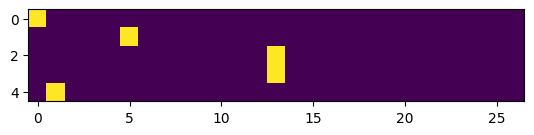

In [110]:
plt.imshow(xenc)

In [120]:
# define the neuron
W = torch.rand((27,1))
xenc @ W # (5,27) @ (27, 1) each element of input is multiplied by the weight matrix and summed up 

tensor([[0.5997],
        [0.4562],
        [0.6851],
        [0.6851],
        [0.2978]])

In [122]:
# we want to have 27 neurons instea dof 1
W = torch.rand((27,27))
xenc @ W # output is (5,27)

tensor([[0.1194, 0.6991, 0.3688, 0.2250, 0.4608, 0.7862, 0.6150, 0.9812, 0.6490,
         0.5949, 0.3367, 0.7054, 0.7325, 0.4151, 0.8045, 0.8340, 0.1484, 0.6363,
         0.0428, 0.1780, 0.0411, 0.1507, 0.3802, 0.2448, 0.6101, 0.8423, 0.5573],
        [0.3020, 0.1300, 0.2386, 0.6560, 0.7362, 0.1846, 0.3546, 0.2382, 0.9782,
         0.0930, 0.2634, 0.5244, 0.1735, 0.6869, 0.1447, 0.8404, 0.1200, 0.0112,
         0.5669, 0.7247, 0.1362, 0.0681, 0.6897, 0.5581, 0.5267, 0.7208, 0.0721],
        [0.7815, 0.8797, 0.5233, 0.7143, 0.3736, 0.7753, 0.0444, 0.9507, 0.8311,
         0.9812, 0.0756, 0.1630, 0.3408, 0.8236, 0.1289, 0.6519, 0.2580, 0.3917,
         0.6872, 0.9546, 0.7968, 0.5029, 0.3487, 0.4279, 0.1617, 0.7694, 0.5547],
        [0.7815, 0.8797, 0.5233, 0.7143, 0.3736, 0.7753, 0.0444, 0.9507, 0.8311,
         0.9812, 0.0756, 0.1630, 0.3408, 0.8236, 0.1289, 0.6519, 0.2580, 0.3917,
         0.6872, 0.9546, 0.7968, 0.5029, 0.3487, 0.4279, 0.1617, 0.7694, 0.5547],
        [0.3509, 0.8519,

Above matrix is the firing rate for each neuron to 5 inputs

In [121]:
# what si firing rate of the 10 neuron for 2nd input
(xenc @ W)[2, 10]


IndexError: index 10 is out of bounds for dimension 1 with size 1

In [ ]:
# interpresst the output of the neuron as probabilities
# we are trying to predict the probability of the next character given the previous character
# (5, 27) @ (27, 27) = (5, 27)
# the output of the NN will be 27 numbers per input. these numebrs are  log counts
# to get count we need to exponentiate the output
# we need to convert these numbers to probabilities by dividing by the sum of the row

In [116]:
(xenc @ W).exp()

tensor([[1.5662, 1.3228, 1.3142, 1.2114, 1.9638, 1.8983, 1.6607, 2.1747, 1.4939,
         1.3153, 1.4959, 2.3734, 2.2390, 1.2051, 1.9693, 1.2238, 1.5965, 1.8844,
         1.4296, 2.1604, 1.6695, 2.1084, 1.2803, 2.1691, 2.6940, 2.7073, 1.4091],
        [1.6426, 1.4828, 1.5969, 1.1485, 1.1938, 1.4853, 1.8019, 1.1216, 2.3850,
         2.4297, 1.1456, 2.3920, 1.8345, 2.2158, 2.0098, 2.3917, 2.1865, 1.4361,
         1.6765, 2.0858, 1.1984, 2.6739, 1.6598, 1.6913, 2.5143, 2.5608, 1.0679],
        [1.1140, 1.6692, 1.3528, 1.2501, 1.7394, 1.4647, 1.6948, 1.0007, 1.4315,
         1.0434, 1.2567, 1.1332, 1.0027, 1.1628, 1.0326, 1.9124, 2.3867, 2.6669,
         2.6182, 2.6406, 1.1025, 2.0684, 1.3052, 1.0865, 1.4891, 1.3755, 1.6268],
        [1.1140, 1.6692, 1.3528, 1.2501, 1.7394, 1.4647, 1.6948, 1.0007, 1.4315,
         1.0434, 1.2567, 1.1332, 1.0027, 1.1628, 1.0326, 1.9124, 2.3867, 2.6669,
         2.6182, 2.6406, 1.1025, 2.0684, 1.3052, 1.0865, 1.4891, 1.3755, 1.6268],
        [2.1419, 1.8739,

In [123]:
#logits (log counts)
logits = xenc @ W
counts = logits.exp() # equavalent to N
probs = counts / counts.sum(dim=1, keepdim=True) # equivalent to P
probs


tensor([[0.0247, 0.0442, 0.0317, 0.0275, 0.0348, 0.0482, 0.0406, 0.0586, 0.0420,
         0.0398, 0.0307, 0.0444, 0.0457, 0.0332, 0.0491, 0.0505, 0.0255, 0.0415,
         0.0229, 0.0262, 0.0229, 0.0255, 0.0321, 0.0280, 0.0404, 0.0510, 0.0383],
        [0.0323, 0.0272, 0.0304, 0.0461, 0.0499, 0.0288, 0.0341, 0.0303, 0.0636,
         0.0262, 0.0311, 0.0404, 0.0284, 0.0475, 0.0276, 0.0554, 0.0270, 0.0242,
         0.0422, 0.0494, 0.0274, 0.0256, 0.0477, 0.0418, 0.0405, 0.0492, 0.0257],
        [0.0448, 0.0494, 0.0346, 0.0419, 0.0298, 0.0445, 0.0214, 0.0530, 0.0470,
         0.0547, 0.0221, 0.0241, 0.0288, 0.0467, 0.0233, 0.0393, 0.0265, 0.0303,
         0.0407, 0.0532, 0.0455, 0.0339, 0.0290, 0.0314, 0.0241, 0.0442, 0.0357],
        [0.0448, 0.0494, 0.0346, 0.0419, 0.0298, 0.0445, 0.0214, 0.0530, 0.0470,
         0.0547, 0.0221, 0.0241, 0.0288, 0.0467, 0.0233, 0.0393, 0.0265, 0.0303,
         0.0407, 0.0532, 0.0455, 0.0339, 0.0290, 0.0314, 0.0241, 0.0442, 0.0357],
        [0.0302, 0.0499,

softmax converts output into probabilities similar to logits and row wise normalising it.

In [124]:
probs[0].sum()

tensor(1.0000)

We do above to make sure the operation is differentiable so that we can do backpropagation

In [125]:
g = torch.Generator().manual_seed(2147483647)
W = torch.rand((27,27), generator=g)    # deterministic random numbers

In [126]:
xenc = F.one_hot(xs, num_classes=27).float() # input to the network is one-hot encoded
logits = xenc @ W # output of the network is log counts
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)
# last 2 lines are called softmax

In [127]:
probs.shape

torch.Size([5, 27])

In [129]:
nlls = torch.zeros(5)
for i in range(5):
    x = xs[i].item()
    y = ys[i].item()
    print('--------')
    print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
    print('input to the neural net:', x)
    print('output probabilities from the neural net:', probs[i])
    print('label (actual next character):', y)
    p = probs[i, y]
    print('probability assigned by the net to the the correct character:', p.item())
    logp = torch.log(p)
    print('log likelihood:', logp.item())
    nll = -logp
    print('negative log likelihood:', nll.item())
    nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------
bigram example 1: .e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0426, 0.0299, 0.0233, 0.0382, 0.0229, 0.0229, 0.0507, 0.0563, 0.0211,
        0.0280, 0.0440, 0.0313, 0.0497, 0.0439, 0.0308, 0.0261, 0.0424, 0.0563,
        0.0547, 0.0325, 0.0425, 0.0222, 0.0472, 0.0285, 0.0566, 0.0295, 0.0258])
label (actual next character): 5
probability assigned by the net to the the correct character: 0.022935139015316963
log likelihood: -3.775084972381592
negative log likelihood: 3.775084972381592
--------
bigram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0298, 0.0278, 0.0241, 0.0308, 0.0300, 0.0362, 0.0401, 0.0269, 0.0538,
        0.0445, 0.0560, 0.0239, 0.0358, 0.0258, 0.0370, 0.0542, 0.0275, 0.0513,
        0.0263, 0.0253, 0.0315, 0.0294, 0.0317, 0.0507, 0.0554, 0.0562, 0.0380])
label (actual next character): 13
probability assigned by the net to the the correct character: 0

Overall above loss (negative log likelihood is quite high)
we can change the W and see what difference makes. But this more tiral and erorr approach

We can use gradient approach here 

In [142]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True) # requires_grad=True to compute gradients

In [151]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(5), ys].log().mean() # extract the probs ys indexes and calculate the mean
loss

tensor(3.7653, grad_fn=<NegBackward0>)

In [137]:
probs[0, 5,], probs[1, 13], probs[2,13], probs[3, 1], probs[4,0]
# above is same as 
probs[torch.arange(5), ys]

tensor([0.0123, 0.0181, 0.0267, 0.0737, 0.0150], grad_fn=<IndexBackward0>)

In [148]:
# backward pass
W.grad = None # more efficient than zero_grad
loss.backward()

In [149]:
W.data += -0.01 * W.grad

In [ ]:
# ----- OPTIMISATION -------------

In [153]:
# create the dataset
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples:  228146


In [156]:
for k in range(100):
    # forward pass
    xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
    logits = xenc @ W # predict log-counts
    counts = logits.exp() 
    probs = counts / counts.sum(dim=1, keepdim=True)
    loss = -probs[torch.arange(num), ys].log().mean()

    
    # backward pass
    W.grad = None
    loss.backward()

    # optimization
    W.data += -50 * W.grad

    print(f'iteration {k+1}, loss: {loss.item()}')

iteration 1, loss: 3.371100902557373
iteration 2, loss: 3.154043197631836
iteration 3, loss: 3.020373821258545
iteration 4, loss: 2.927711248397827
iteration 5, loss: 2.8604023456573486
iteration 6, loss: 2.8097290992736816
iteration 7, loss: 2.7701022624969482
iteration 8, loss: 2.7380728721618652
iteration 9, loss: 2.711496591567993
iteration 10, loss: 2.6890032291412354
iteration 11, loss: 2.6696884632110596
iteration 12, loss: 2.6529300212860107
iteration 13, loss: 2.638277292251587
iteration 14, loss: 2.6253881454467773
iteration 15, loss: 2.613990545272827
iteration 16, loss: 2.60386323928833
iteration 17, loss: 2.5948219299316406
iteration 18, loss: 2.5867116451263428
iteration 19, loss: 2.579403877258301
iteration 20, loss: 2.572789192199707
iteration 21, loss: 2.5667762756347656
iteration 22, loss: 2.5612878799438477
iteration 23, loss: 2.5562586784362793
iteration 24, loss: 2.551633596420288
iteration 25, loss: 2.547365665435791
iteration 26, loss: 2.543415069580078
iteration

We can optimise above code a bit. 
Element-wise multiplication takes the one-hot encoding, picks the approproaite row multiplies it with the matrix and sums it up.

## Loss Regularisation
The weight matrix W, 
- if all elements in W are 0.0. or equal, logits will become zero, counts will become 1 and probs will be uniform.
- Trying to keep W close 0 is similar to model smoothing or label smoothing.

We augment the loss function to ahve a small component call regularisation loss to get uniform distriutions. We doo that by taking entries of the W, squaring them and taking a sum/mean of them. Then we add to the loss


In [158]:
# add regularization loss
for k in range(100):
    # forward pass
    xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
    logits = xenc @ W # predict log-counts
    counts = logits.exp() 
    probs = counts / counts.sum(dim=1, keepdim=True)
    loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean() # add regularization loss
        #0.01 is the strength of regularisation. this is simialr to adding small or large number to counts
    
    # backward pass
    W.grad = None
    loss.backward()

    # optimization
    W.data += -50 * W.grad

    print(f'iteration {k+1}, loss: {loss.item()}')

iteration 1, loss: 2.489370584487915
iteration 2, loss: 2.4892220497131348
iteration 3, loss: 2.489079475402832
iteration 4, loss: 2.488940954208374
iteration 5, loss: 2.4888064861297607
iteration 6, loss: 2.488675594329834
iteration 7, loss: 2.4885478019714355
iteration 8, loss: 2.4884235858917236
iteration 9, loss: 2.48830246925354
iteration 10, loss: 2.4881839752197266
iteration 11, loss: 2.488068103790283
iteration 12, loss: 2.487955093383789
iteration 13, loss: 2.487844705581665
iteration 14, loss: 2.487736701965332
iteration 15, loss: 2.487631320953369
iteration 16, loss: 2.487527847290039
iteration 17, loss: 2.487427234649658
iteration 18, loss: 2.487328290939331
iteration 19, loss: 2.487231492996216
iteration 20, loss: 2.4871363639831543
iteration 21, loss: 2.487043857574463
iteration 22, loss: 2.4869532585144043
iteration 23, loss: 2.4868640899658203
iteration 24, loss: 2.486776828765869
iteration 25, loss: 2.486691474914551
iteration 26, loss: 2.486607789993286
iteration 27, 

In [159]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  
  out = []
  ix = 0
  while True:
    
    # ----------
    # BEFORE:
    #p = P[ix]
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------
    
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

cexze.
momasurailezityha.
konimittain.
llayn.
ka.


[Part2](https://www.youtube.com/watch?v=TCH_1BHY58I)